# CheXpert Dataset Preprocessing

In [ ]:
!pip install barbar

import numpy as np
import pandas as pd
import time
import csv
import random
import matplotlib.pyplot as plt
from PIL import Image
from barbar import Bar

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score

import albumentations as A
from albumentations.augmentations.transforms import CLAHE
from albumentations.pytorch.transforms import ToTensorV2

use_gpu = torch.cuda.is_available()
print(use_gpu)

False


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/ai_for_healthcare/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: CheXpert-v1.0-small/train/patient60445/study2/view1_frontal.jpg  
  inflating: CheXpert-v1.0-small/train/patient60445/study2/view2_lateral.jpg  
  inflating: CheXpert-v1.0-small/train/patient60446/study1/view1_frontal.jpg  
  inflating: CheXpert-v1.0-small/train/patient60446/study2/view1_frontal.jpg  
  inflating: CheXpert-v1.0-small/train/patient60446/study2/view2_lateral.jpg  
  inflating: CheXpert-v1.0-small/train/patient60447/study1/view1_frontal.jpg  
  inflating: CheXpert-v1.0-small/train/patient60447/study1/view2_lateral.jpg  
  inflating: CheXpert-v1.0-small/train/patient60448/study1/view1_frontal.jpg  
  inflating: CheXpert-v1.0-small/train/patient60448/study1/view2_lateral.jpg  
  inflating: CheXpert-v1.0-small/train/patient60448/study1/view3_lateral.jpg  
  inflating: CheXpert-v1.0-small/train/patient60449/study1/view1_frontal.jpg  
  inflating: CheXpert-v1.0-small/train/patient60449/study1/view2_lateral.jpg  
 

In [ ]:
# specify unwanted columns
columns_to_drop = ['Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding', 'Enlarged Cardiomediastinum', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Atelectasis', 'Pneumothorax', 'Pleural Other', 'Fracture', 'Support Devices']

Traindata = pd.read_csv('CheXpert-v1.0-small/train.csv') # read train.csv
Traindata = Traindata.drop(columns=columns_to_drop) # Getting rid of everything except the 3 diseases that we need
Traindata = Traindata[Traindata['Path'].str.contains("frontal")] # use only frontal images
Traindata = Traindata[500:] # data 500 to the end
Traindata.to_csv('./CheXpert-v1.0-small/train_mod.csv', index = False) #Convert to CSV
print("Train data length:", len(Traindata))
print(Traindata)

Validdata = pd.read_csv('./CheXpert-v1.0-small/valid.csv') # read valid.csv
Validdata = Validdata.drop(columns=columns_to_drop) # Getting rid of everything except the 3 diseases that we need
Validdata = Validdata[Validdata['Path'].str.contains("frontal")] # use only frontal images
Validdata.to_csv('./CheXpert-v1.0-small/valid_mod.csv', index = False) #Convert to CSV
print("Valid data length:", len(Validdata))

Testdata = Traindata[:500] # train data is 500 to the end
Testdata.to_csv('./CheXpert-v1.0-small/test_mod.csv', index = False) #Convert to CSV
print("Test data length:", len(Testdata))

pathFileTrain = './CheXpert-v1.0-small/train_mod.csv'
pathFileValid = './CheXpert-v1.0-small/valid_mod.csv'
pathFileTest = './CheXpert-v1.0-small/test_mod.csv'

nnIsTrained = False     # Not pre-trained
nnClassCount = 4        # Dimension of the output (edema, cardiomegaly, pneumonia, nothing)

trBatchSize = 16        # Batch size
trMaxEpoch = 3          # Epoch

# Image transformation here
imgtransResize = (320, 320)
imgtransCrop = 250
gamma_value = 1.0

class_names = ['Cardiomegaly', 'Pneumonia', 'Pleural Effusion', 'Nothing']

Train data length: 190527
                                                     Path  Cardiomegaly  \
621     CheXpert-v1.0-small/train/patient00147/study13...           NaN   
622     CheXpert-v1.0-small/train/patient00147/study8/...           NaN   
623     CheXpert-v1.0-small/train/patient00147/study14...           NaN   
624     CheXpert-v1.0-small/train/patient00147/study10...           NaN   
625     CheXpert-v1.0-small/train/patient00147/study9/...           NaN   
...                                                   ...           ...   
223409  CheXpert-v1.0-small/train/patient64537/study2/...           NaN   
223410  CheXpert-v1.0-small/train/patient64537/study1/...           NaN   
223411  CheXpert-v1.0-small/train/patient64538/study1/...           NaN   
223412  CheXpert-v1.0-small/train/patient64539/study1/...           1.0   
223413  CheXpert-v1.0-small/train/patient64540/study1/...           NaN   

        Pneumonia  Pleural Effusion  
621           NaN               1.0

## Create Dataset

In [ ]:
class CheXpertDataSet(Dataset):
    def __init__(self, data_PATH, transform = None, policy = "ones", gamma=1.0, apply_clahe=False):
      image_names = []
      labels = []
      with open(data_PATH, "r") as f:
            csvReader = csv.reader(f)
            next(csvReader, None) # skip the header
            for line in csvReader:
              image_name = line[0]
              label = line[1:] + [0]

              for i in range(4):
                if i == 3:
                  if label[0] == 1 or label[1] == 1 or label[2] == 1:
                    label[i] = 0
                  else:
                    label[i] = 1
                else:
                  if label[i]:
                    a = float(label[i])
                    if a == 1:
                      label[i] = 1
                    elif a == -1:
                      if policy == "ones":
                        label[i] = 1
                      elif policy == "zeroes":
                        label[i] = 0
                      else:
                        label[i] = 0
                    else:
                      label[i] = 0
                  else:
                    label[i] = 0

              image_names.append('./' + image_name)
              labels.append(label)

      self.image_names = image_names
      self.labels = labels
      self.transform = transform

    def __getitem__(self, index):
      """Take the index of item and returns the image and its labels"""
      image_name = self.image_names[index]
      image = Image.open(image_name).convert('RGB')

      # Apply gamma correction
      if hasattr(self, 'gamma') and self.gamma != 1.0:
        image = np.array(image)
        image = gamma_correction(image, gamma=self.gamma)
        image = Image.fromarray(image)

      # Apply CLAHE
      if hasattr(self, 'apply_clahe') and self.apply_clahe:
        image = np.array(image)
        image = apply_clahe(image)
        image = Image.fromarray(image)

      label = self.labels[index]
      if self.transform is not None:
        image = self.transform(image)
      return image, torch.FloatTensor(label)

    def __len__(self):
      return len(self.image_names)

## Preprocessing

### Contrast Limited Adaptive histogram equalization

In [ ]:
def apply_clahe(image, clip_limit=8.0, tile_grid_size=(4, 4), p=1.0, alpha=0):
    clahe_transform = CLAHE(clip_limit=clip_limit, tile_grid_size=tile_grid_size, always_apply=True, p=p)
    augmented = clahe_transform(image=image)
    final_img = augmented['image'] + alpha
    return final_img

### Gamma Correction

In [ ]:
def gamma_correction(image, gamma=1.0):
    """Applies gamma correction to a given image using the specified gamma value.

    Args:
        image (numpy.ndarray): The input image to be corrected.
        gamma (float): The gamma value to use for correction. Default is 1.0 (no correction applied).

    Returns:
        numpy.ndarray: The gamma-corrected image.
    """
    # Ensure gamma is non-negative
    if gamma < 0:
        raise ValueError("Gamma value should be non-negative.")

    # Normalize the image to the [0, 1] range

    normalized_image = image.astype(np.float32) / 255.0

    # Apply gamma correction
    corrected_image = np.power(normalized_image, gamma)

    # Scale the image to the [0, 255] range
    corrected_image = (corrected_image * 255.0).clip(0, 255).astype(np.uint8)

    return corrected_image

class GammaCorrectionTransform:
    def __init__(self, gamma=1.0):
        self.gamma = gamma

    def __call__(self, img):
        img_array = np.array(img)
        corrected_img_array = gamma_correction(img_array, self.gamma)
        return Image.fromarray(corrected_img_array)

In [ ]:
# BELOW ARE SOME TRANSFORMATION CODES

IMAGENET_MEAN = [0.485, 0.456, 0.406]  # mean of ImageNet dataset(for normalization)
IMAGENET_STD = [0.229, 0.224, 0.225]   # std of ImageNet dataset(for normalization) DO NOT KNOW WHAT THIS MEANS

# Tranform data
normalize = transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
transformList = []

# add preprocessing
transformList.append(transforms.Resize(imgtransResize)) # 224
transformList.append(transforms.CenterCrop(imgtransCrop))
transformList.append(transforms.Lambda(lambda x: gamma_correction(np.array(x), gamma=gamma_value)))
#transformList.append(transforms.RandomHorizontalFlip())
transformList.append(transforms.ToTensor())
#transformList.append(normalize)
transformSequence = transforms.Compose(transformList)

datasetTrain = CheXpertDataSet(pathFileTrain, transformSequence, policy = "ones", gamma=1.0, apply_clahe=True) # set apply_clahe to be False if don't want to apply
print("Train data length:", len(datasetTrain))

datasetValid = CheXpertDataSet(pathFileValid, transformSequence, gamma=1.0, apply_clahe=True) # set apply_clahe to be False if don't want to apply
print("Valid data length:", len(datasetValid))

datasetTest = CheXpertDataSet(pathFileTest, transformSequence, policy = "ones", gamma=1.0, apply_clahe=True) # set apply_clahe to be False if don't want to apply
print("Test data length:", len(datasetTest))

Train data length: 190527
Valid data length: 202
Test data length: 500


In [ ]:
print(pathFileTrain)

./CheXpert-v1.0-small/train_mod.csv


## Show an actual preprocessed image

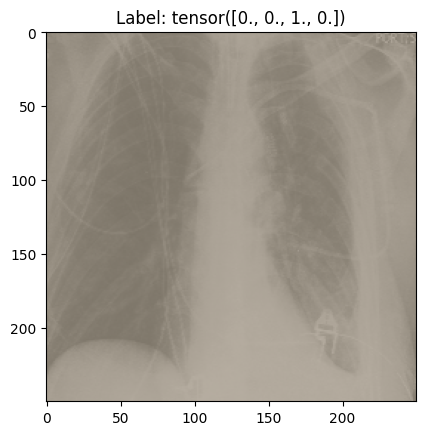

In [ ]:
# Display the actual image of datasetTrain[0]
sample_image, sample_label = datasetTrain[5]

# Convert torch tensor to NumPy array and transpose the channels
sample_image_np = sample_image.numpy().transpose((1, 2, 0))

# Denormalize the image (assuming it was normalized during the transformation)
sample_image_np = sample_image_np * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)

# Clip values to be in the valid range [0, 1]
sample_image_np = np.clip(sample_image_np, 0, 1)

plt.imshow(sample_image_np)
plt.title(f"Label: {sample_label}")
plt.show()